# HVAC with Amazon SageMaker RL


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

---


---
## Introduction


HVAC stands for Heating, Ventilation and Air Conditioning and is responsible for keeping us warm and comfortable indoors.  HVAC takes up a whopping 50% of the energy in a building and accounts for 40% of energy use in the US [1, 2]. Several control system optimizations have been proposed to reduce energy usage while ensuring thermal comfort.

Modern buildings collect data about the weather, occupancy and equipment use. All of this can be used to optimize HVAC energy usage. Reinforcement Learning (RL) is a good fit because it can learn how to interact with the environment and identify strategies to limit wasted energy. Several recent research efforts have shown that RL can reduce HVAC energy consumption by 15-20% [3, 4].

As training an RL algorithm in a real HVAC system can take time to converge as well as potentially lead to hazardous settings as the agent explores its state space, we turn to a simulator to train the agent. [EnergyPlus](https://energyplus.net/) is an open source, state of the art HVAC simulator from the US Department of Energy. We use a simple example with this simulator to showcase how we can train an RL model easily with Amazon SageMaker RL.

<br>

<img width="85%" src="images/datacenter_env.png" />

<br>

1. Objective: Control the data center HVAC system to reduce energy consumption while ensuring the room temperature stays within specified limits.
2. Environment: We have a small single room datacenter that the HVAC system is cooling to ensure the compute equipment works properly. We will train our RL agent to control this HVAC system for one day subject to weather conditions in San Francisco.  The agent takes actions every 5 minutes for a 24 hour period. Hence, the episode is a fixed 120 steps. 
3. State: The outdoor temperature, outdoor humidity and indoor room temperature.
4. Action: The agent can set the heating and cooling setpoints. The cooling setpoint tells the HVAC system that it should start cooling the room if the room temperature goes above this setpoint. Likewise, the HVAC systems starts heating if the room temperature goes below the heating setpoint.
5. Reward: The rewards has two components which are added together with coefficients: 
    1. It is proportional to the energy consumed by the HVAC system.
    2. It gets a large penalty when the room temperature exceeds pre-specified lower or upper limits (as defined in `data_center_env.py`).

References

1. [sciencedirect.com](https://www.sciencedirect.com/science/article/pii/S0378778807001016)
2. [environment.gov.au](https://www.environment.gov.au/system/files/energy/files/hvac-factsheet-energy-breakdown.pdf)
3. Wei, Tianshu, Yanzhi Wang, and Qi Zhu. "Deep reinforcement learning for building hvac control." In Proceedings of the 54th Annual Design Automation Conference 2017, p. 22. ACM, 2017.
4. Zhang, Zhiang, and Khee Poh Lam. "Practical implementation and evaluation of deep reinforcement learning control for a radiant heating system." In Proceedings of the 5th Conference on Systems for Built Environments, pp. 148-157. ACM, 2018.

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime

sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/base_serializers.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  import scipy.sparse


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Setup S3 bucket

Create a reference to the default S3 bucket that will be used for model outputs.

In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()
s3_output_path = "s3://{}/".format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-ap-northeast-2-211125790189/


### Define Variables 

We define a job below that's used to identify our jobs.

In [3]:
# create unique job name
job_name_prefix = "rl-hvac"

### Configure settings

You can run your RL training jobs locally on the SageMaker notebook instance or on SageMaker training. In both of these scenarios, you can run in either 'local' (where you run the commands) or 'SageMaker' mode (on SageMaker training instances). 'local' mode uses the SageMaker Python SDK to run your code in Docker containers locally. It can speed up iterative testing and debugging while using the same familiar Python SDK interface. Just set `local_mode = True`. And when you're ready move to 'SageMaker' mode to scale things up.

In [4]:
# run local (on this machine)?
# or on sagemaker training instances?
local_mode = False

if local_mode:
    instance_type = "local"
else:
    # choose a larger instance to avoid running out of memory
    instance_type = "ml.m4.4xlarge"

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::211125790189:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from your local machine, please make sure that you have docker or docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependencies.

Note, you can only run a single local notebook at one time.

In [6]:
# Only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Build docker container

Since we're working with a custom environment with custom dependencies, we create our own container for training. We:

1. Fetch the base MXNet and Coach container image,
2. Install EnergyPlus and its dependencies on top,
3. Upload the new container image to AWS ECR.

In [7]:
cpu_or_gpu = "gpu" if instance_type.startswith("ml.p") else "cpu"
repository_short_name = "sagemaker-hvac-coach-%s" % cpu_or_gpu
docker_build_args = {
    "CPU_OR_GPU": cpu_or_gpu,
    "AWS_REGION": boto3.Session().region_name,
}
custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using ECR image %s" % custom_image_name)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image sagemaker-hvac-coach-cpu from Dockerfile
$ docker build -t sagemaker-hvac-coach-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=ap-northeast-2
#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 2.04kB done
#1 DONE 0.0s

#2 [auth] sharing credentials for 211125790189.dkr.ecr.ap-northeast-2.amazonaws.com
#2 DONE 0.0s

#3 [internal] load metadata for 211125790189.dkr.ecr.ap-northeast-2.amazonaws.com/sagemaker-rl-mxnet:coach0.11.0-cpu-py3
#3 DONE 0.4s

#4 [internal] load .dockerignore
#4 transferring context: 2B done
#4 DONE 0.0s

#5 [1/

## Setup the environment

The environment is defined in a Python file called `data_center_env.py` and for SageMaker training jobs, the file will be uploaded inside the `/src` directory.

The environment implements the init(), step() and reset() functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment.

1. `init()` - initialize the environment in a pre-defined state
2. `step()` - take an action on the environment
3. `reset()` - restart the environment on a new episode

## Configure the presets for RL algorithm 

The presets that configure the RL training jobs are defined in the “preset-energy-plus-clipped-ppo.py” file which is also uploaded as part of the `/src` directory. Using the preset file, you can define agent parameters to select the specific agent algorithm. You can also set the environment parameters, define the schedule and visualization parameters, and define the graph manager. The schedule presets will define the number of heat up steps, periodic evaluation steps, training steps between evaluations, etc.

All of these can be overridden at run-time by specifying the `RLCOACH_PRESET` hyperparameter. Additionally, it can be used to define custom hyperparameters.

In [8]:
!pygmentize src/preset-energy-plus-clipped-ppo.py

import eplus
from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.architectures.layers import Dense
from rl_coach.base_parameters import (
    DistributedCoachSynchronizationType,
    PresetValidationParameters,
    VisualizationParameters,
)
from rl_coach.core_types import EnvironmentEpisodes, EnvironmentSteps, RunPhase, TrainingSteps
from rl_coach.environments.gym_environment import GymVectorEnvironment, mujoco_v2
from rl_coach.exploration_policies.additive_noise import AdditiveNoiseParameters
from rl_coach.exploration_policies.e_greedy import EGreedyParameters
from rl_coach.filters.observation.observation_normalization_filter import (
    ObservationNormalizationFilter,
)
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

####################
# Graph Scheduling #
####################

schedule_params = Schedu

## Write the Training Code 

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

In [9]:
!pygmentize src/train-coach.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher


class MyLauncher(SageMakerCoachPresetLauncher):
    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return "preset-energy-plus-clipped-ppo"


if __name__ == "__main__":
    MyLauncher.train_main()


## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET can be used to specify the RL agent algorithm you want to use. 
6. [optional] Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [10]:
%%time
estimator = RLEstimator(
    entry_point="train-coach.py",
    source_dir="src",
    dependencies=["common/sagemaker_rl"],
    image_uri=custom_image_name,
    role=role,
    instance_type=instance_type,
    instance_count=1,
    output_path=s3_output_path,
    base_job_name=job_name_prefix,
    hyperparameters={"save_model": 1},
)

estimator.fit(wait=local_mode)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

INFO:sagemaker:Creating training-job with name: rl-hvac-2024-09-30-04-32-11-133


Training job: rl-hvac-2024-09-30-04-32-11-133
CPU times: user 814 ms, sys: 29.8 ms, total: 844 ms
Wall time: 1.5 s


## Store intermediate training output and model checkpoints 

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training.

In [11]:
s3_url = "s3://{}/{}".format(s3_bucket, job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))

tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

S3 job path: s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133
Output.tar.gz location: s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/output/output.tar.gz
Intermediate folder path: s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/output/intermediate/
Create local folder /tmp/rl-hvac-2024-09-30-04-32-11-133


## Visualization

### Plot metrics for training job
We can pull the reward metric of the training and plot it to see the performance of the model over time.

INFO:matplotlib.font_manager:generated new fontManager
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Waiting for s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


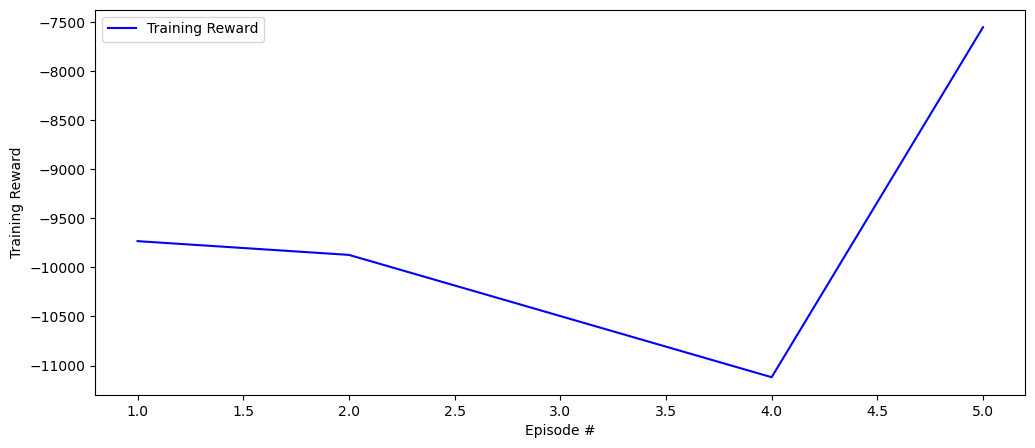

In [12]:
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=["Training Reward"])
x_axis = "Episode #"
y_axis = "Training Reward"

plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
plt.set_ylabel(y_axis)
plt.set_xlabel(x_axis);

## Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

### Load checkpointed model

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [13]:
wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)

if not os.path.isfile("{}/output.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File output.tar.gz not found")
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))

if local_mode:
    checkpoint_dir = "{}/data/checkpoint".format(tmp_dir)
else:
    checkpoint_dir = "{}/checkpoint".format(tmp_dir)

print("Checkpoint directory {}".format(checkpoint_dir))

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Waiting for s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/output/output.tar.gz...
checkpoint/
checkpoint/0_Step-1.ckpt.main_level.agent.main.online.onnx
checkpoint/3_Step-865.ckpt.main_level.agent.main.online
checkpoint/4_Step-1001.ckpt.main_level.agent.filters.pre_network_filter.observation_filters.observation.normalize_observation.srs
checkpoint/7_Step-1865.ckpt.main_level.agent.filters.pre_network_filter.observation_filters.observation.normalize_observation.srs
checkpoint/5_Step-1289.ckpt.main_level.agent.main.online.onnx
checkpoint/4_Step-1001.ckpt.main_level.agent.main.online.onnx
checkpoint/0_Step-1.ckpt.main_level.agent.filters.pre_network_filter.observation_filters.observation.normalize_observation.srs
checkpoint/6_Step-1577.ckpt.main_level.agent.main.online
checkpoint/7_Step-1865.ckpt.main_level.agent.main.online
checkpoint/5_Step-1289.ckpt.main_level.agent.main.online
checkpoint/3_Step-865.ckpt.main_level.agent.main.online.onnx
checkpoint/6_Step-1

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creati

In [14]:
if local_mode:
    checkpoint_path = "file://{}".format(checkpoint_dir)
    print("Local checkpoint file path: {}".format(checkpoint_path))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

upload: ../../../../../tmp/rl-hvac-2024-09-30-04-32-11-133/checkpoint/.coach_checkpoint to s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/checkpoint/.coach_checkpoint
upload: ../../../../../tmp/rl-hvac-2024-09-30-04-32-11-133/checkpoint/0_Step-1.ckpt.main_level.agent.filters.pre_network_filter.observation_filters.observation.normalize_observation.srs to s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/checkpoint/0_Step-1.ckpt.main_level.agent.filters.pre_network_filter.observation_filters.observation.normalize_observation.srs
upload: ../../../../../tmp/rl-hvac-2024-09-30-04-32-11-133/checkpoint/0_Step-1.ckpt.main_level.agent.main.online to s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/checkpoint/0_Step-1.ckpt.main_level.agent.main.online
upload: ../../../../../tmp/rl-hvac-2024-09-30-04-32-11-133/checkpoint/0_Step-1.ckpt.main_level.agent.main.online.onnx to s3://sagemaker-ap-northeast-2-211125790189/rl-hv

### Run the evaluation step

Use the checkpointed model to run the evaluation step. 

In [15]:
estimator_eval = RLEstimator(
    entry_point="evaluate-coach.py",
    source_dir="src",
    dependencies=["common/sagemaker_rl"],
    image_uri=custom_image_name,
    role=role,
    instance_type=instance_type,
    instance_count=1,
    output_path=s3_output_path,
    base_job_name=job_name_prefix + "-evaluation",
    hyperparameters={
        "RLCOACH_PRESET": "preset-energy-plus-clipped-ppo",
        "evaluate_steps": 288 * 2,  # 2 episodes, i.e. 2 days
    },
)

estimator_eval.fit({"checkpoint": checkpoint_path})

INFO:sagemaker:Creating training-job with name: rl-hvac-evaluation-2024-09-30-04-38-03-961


2024-09-30 04:38:06 Starting - Starting the training job...
2024-09-30 04:38:20 Starting - Preparing the instances for training...
2024-09-30 04:39:01 Downloading - Downloading the training image...
2024-09-30 04:39:22 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-09-30 04:39:43,057 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2024-09-30 04:39:43,061 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-09-30 04:39:43,076 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_DIR': '/opt/ml/input', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.m4.4xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"],"instance_group_name":"homogeneousCluster","instance_type":"ml.m4.4xlarge"

## Model deployment

Since we specified MXNet when configuring the RLEstimator, the MXNet deployment container will be used for hosting.

In [16]:
from sagemaker.mxnet.model import MXNetModel

model = MXNetModel(
    model_data=estimator.model_data,
    entry_point="src/deploy-mxnet-coach.py",
    framework_version="1.8.0",
    py_version="py37",
    role=role,
)

predictor = model.deploy(initial_instance_count=1, instance_type=instance_type)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-ap-northeast-2-211125790189/rl-hvac-2024-09-30-04-32-11-133/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-northeast-2-211125790189/mxnet-inference-2024-09-30-04-41-28-560/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: mxnet-inference-2024-09-30-04-41-29-234
INFO:sagemaker:Creating endpoint-config with name mxnet-inference-2024-09-30-04-41-29-855
INFO:sagemaker:Creating endpoint with name mxnet-inference-2024-09-30-04-41-29-855


-----!

We can test the endpoint with a samples observation, where the current room temperature is high. Since the environment vector was of the form `[outdoor_temperature, outdoor_humidity, indoor_humidity]` and we used observation normalization in our preset, we choose an observation of `[0, 0, 2]`. Since we're deploying a PPO model, our model returns both state value and actions.

In [17]:
action, action_mean, action_std = predictor.predict(
    np.array(
        [
            0.0,
            0.0,
            2.0,
        ]
    )
)
action_mean

[[-0.17807850241661072, -0.0466604046523571]]

We can see heating and cooling setpoints are returned from the model, and these can be used to control the HVAC system for efficient energy usage. More training iterations will help improve the model further.

### Clean up endpoint

In [18]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: mxnet-inference-2024-09-30-04-41-29-855
INFO:sagemaker:Deleting endpoint with name: mxnet-inference-2024-09-30-04-41-29-855


## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/reinforcement_learning|rl_hvac_coach_energyplus|rl_hvac_coach_energyplus.ipynb)
